## Twins analysis - part 2

##### recap of last time

dataset

what regressions did we do last time?

##### plan for today

to begin to go down the road of 

[Almond, Douglas, Kenneth Y. Chay, and David S. Lee. "The costs of low birth weight." 
The Quarterly Journal of Economics 120.3 (2005): 1031-1083.](https://www.princeton.edu/~davidlee/wp/birthweight.pdf)

(very) rough summary of the goal of the above paper:

much has been made of the negative health implications of low birth weight - but how bad is it really?

twins data sets up conditions for a natural experiment

`health outcomes` ???

1. mortality - survival rate
2. the amount of money spent at the hospital on immediate care after birth
3. ...

the only health outcome we have available is mortality

the health outcome for infant $i$ and mother $j$ we will refer to as $h_{ij}$

$h_{ij} = f(bw_{i}, X_{j}, a_{j}) + \epsilon$


$h_{ij} = bw_{ij}\cdot\beta + X_{j}\cdot\beta_{X} + \epsilon$


the main objective is to accurately estimate the $\beta$ for $bw$

the first approach is to fit this regression:

$h_{ij} = bw_{ij}\cdot\beta + X_{j}\cdot\beta_{X} + \epsilon$

the authors take another approach as well, which looks like this:

$h_{1j} -  h_{0j} = (bw_{1j} - bw_{0j})\cdot\beta + \epsilon$




In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import graphviz as gr
import os

def twins_data():
    twin_pairs_dfs = []

    for file in os.listdir('../data/'):
        if 'twin_pairs' in file:
            df = pd.read_csv(f"../data/{file}")
            unwanted_columns = [col for col in df.columns if 'Unnamed' in col]
            df.drop(columns=unwanted_columns,inplace=True)
            twin_pairs_dfs.append(df)

    df = pd.concat(twin_pairs_dfs, axis=1)

    return df


In [51]:
df = twins_data()
df.head(3)

,dbirwt_0,dbirwt_1,mort_0,mort_1,pldel,birattnd,brstate,stoccfipb,mager8,ormoth,...,feduc6,infant_id_0,infant_id_1,dlivord_min,dtotord_min,bord_0,bord_1,brstate_reg,stoccfipb_reg,mplbir_reg
0,2268.0,2296.0,0.0,0.0,1.0,1.0,1,1,3,0.0,...,NaN,1,0,NaN,NaN,NaN,NaN,5,5,1.0
1,2610.0,2650.0,0.0,0.0,1.0,1.0,1,1,3,0.0,...,NaN,7,6,2.0,3.0,2.0,1.0,5,5,5.0
2,1985.0,2098.0,0.0,0.0,1.0,1.0,1,1,5,0.0,...,3.0,11,10,NaN,NaN,NaN,NaN,5,5,1.0


In [52]:
# health outcome is mortality - it can take a value of 0 or a value of 1
# 0 means the infant survived, 1 means they did not
# mort_0, mort_1
df[['mort_0','mort_1']].head(3)

# we have two approaches to modeling the health outcome
# in the first approach we model per infant 
# in the second approach we take a difference between the health outcomes 

# mort_0 - mort_1 -> both survive (0 - 0 = 0), both not survive (1 - 1  = 0) 
# mort_1 - mort_0

# mort_0 = 1, mort_1 = 1 - > mort_0 + mort_1 = 2
# 2 - (mort_0 + mort_1)
# the worst outcome gives a value of 0
# and the best outcome gives a value of 2
# and the bad/but not worst outcome gives a value of 1
# "bigger value = better" 

# DISCLAIMER - our "mortality score" is not the most natural approach
# mortality is a categorical outcome - a LOGIT regression is preferred here
# but we haven't talked about that yet

,mort_0,mort_1
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0


In [53]:
# create the outcome variable
# df.drop(columns = ['health_outcome'],inplace = True)
df['health_outcome_combined'] = 2 - (df["mort_0"] + df["mort_1"])
df['health_outcome_combined'].value_counts(normalize=True)

health_outcome_combined
2.0    0.949681
1.0    0.028818
0.0    0.021501
Name: proportion, dtype: float64

In [54]:
# reminder of our goal - how does the birthweight influence health_outcome

# because we have combined the health outcome of the twins

# the predictor (birthweight) should also be a combination of the twin birthweights

# this way, we avoid having to control for mother specific determinants of health

# bw_difference = bw_1 - bw0

# y = f(x) -> health_outcome_combined = f(bw_difference) 

# we need to create bw_difference

df['bw_difference'] = df['dbirwt_1'] - df['dbirwt_0']

# we'll also make some other ways to combine bw, in case the difference doesn't yield promising results

# sum

df['combined_weight'] = df['dbirwt_0'] + df['dbirwt_1']

# ratio

df['ratio_weight'] = df['dbirwt_1']/df['dbirwt_0']

# quick inspection of bw difference

df['bw_difference'].describe()

count    71345.000000
mean       283.849688
std        251.996141
min          1.000000
25%        100.000000
50%        220.000000
75%        397.000000
max       6350.000000
Name: bw_difference, dtype: float64

In [55]:
result = smf.ols(formula='health_outcome_combined ~ bw_difference',data=df[['health_outcome_combined','bw_difference']]).fit()
result.params

Intercept        1.899215
bw_difference    0.000102
dtype: float64

In [56]:
# usually you'll hear people say:
# "for a unit change in the predictor (x) (if you add 1 to the predictor) we expect a beta change in the predicted value (y)"

# we want to say something more like:
# "for a change of 100 grams in bw_difference we expect a .01 increase in health_outcome_combined"

result.summary().tables[0]

Dep. Variable:,health_outcome_combined,R-squared:,0.006
Model:,OLS,Adj. R-squared:,0.006
Method:,Least Squares,F-statistic:,432.8
Date:,"Fri, 28 Jun 2024",Prob (F-statistic):,7.83e-96
Time:,10:31:43,Log-Likelihood:,-22170.
No. Observations:,71345,AIC:,4.434e+04
Df Residuals:,71343,BIC:,4.436e+04
Df Model:,1,,
Covariance Type:,nonrobust,,


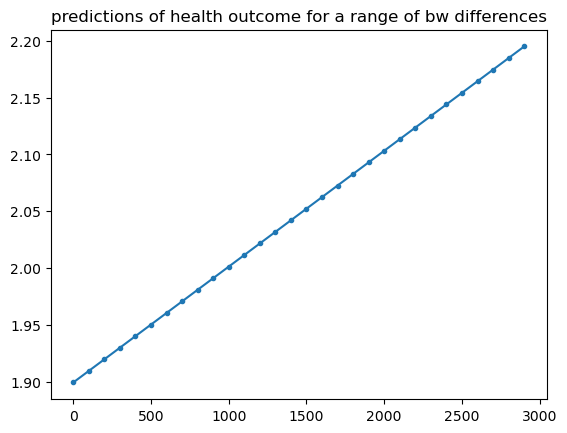

In [57]:
def health_outcome_regression_formula(bw_difference,intercept = 1.899215,beta_bw_difference = 0.000102):

    prediction = intercept + beta_bw_difference*bw_difference

    return prediction

input_bw_differences = np.arange(0,3000,100)

predictions = [health_outcome_regression_formula(bw_difference) for bw_difference in input_bw_differences]

plt.figure()
plt.plot(input_bw_differences,predictions,marker = ".")
plt.title("predictions of health outcome for a range of bw differences")
plt.show()

In [58]:
# at first glance - this makes no sense
# but after some reflection, it does make sense that there would be a tighter range in the double mortality case
# the bw distributions for these groups are probably waaaay different to begin with

df.groupby("health_outcome_combined")['bw_difference'].mean()

health_outcome_combined
0.0    120.775750
1.0    302.336576
2.0    286.980769
Name: bw_difference, dtype: float64

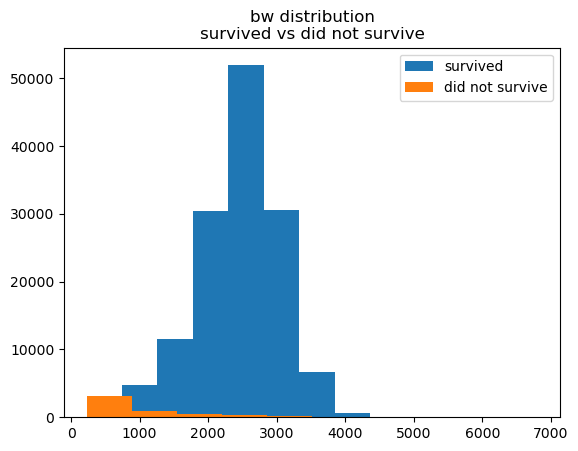

In [67]:
# central tendency and spread of bw depending on mortality outcome

# histograms / boxplots split by mort = 1 and mort = 0

mort_equals_1 = pd.concat([df.loc[df['mort_0'] == 1,'dbirwt_0'],df.loc[df['mort_1'] == 1,'dbirwt_1']]).to_frame()
mort_equals_0 = pd.concat([df.loc[df['mort_0'] == 0,'dbirwt_0'],df.loc[df['mort_1'] == 0,'dbirwt_1']]).to_frame()

plt.figure()
plt.hist(mort_equals_0,label="survived")
plt.hist(mort_equals_1,label="did not survive")
plt.title("bw distribution\nsurvived vs did not survive")
plt.legend()
plt.show()

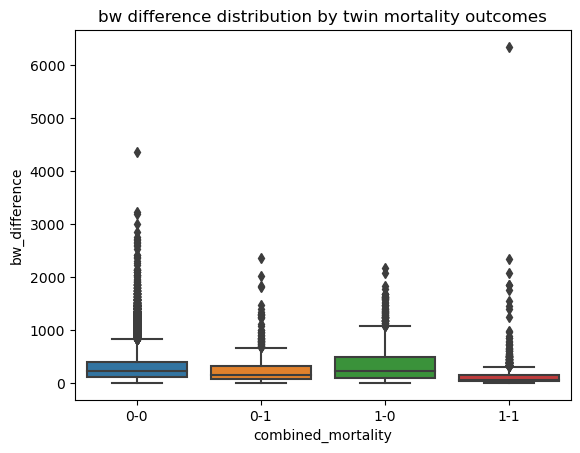

In [60]:
# a little bit more EDA
# distribution of birthweight differences depending on mortality outcomes
import seaborn as sns

# 00 01 10 11

df['combined_mortality'] = df['mort_0'].astype(int).astype(str) + "-" + df['mort_1'].astype(int).astype(str)

plt.figure()
sns.boxplot(x = 'combined_mortality',y = 'bw_difference',data = df)
plt.title("bw difference distribution by twin mortality outcomes")
plt.show()



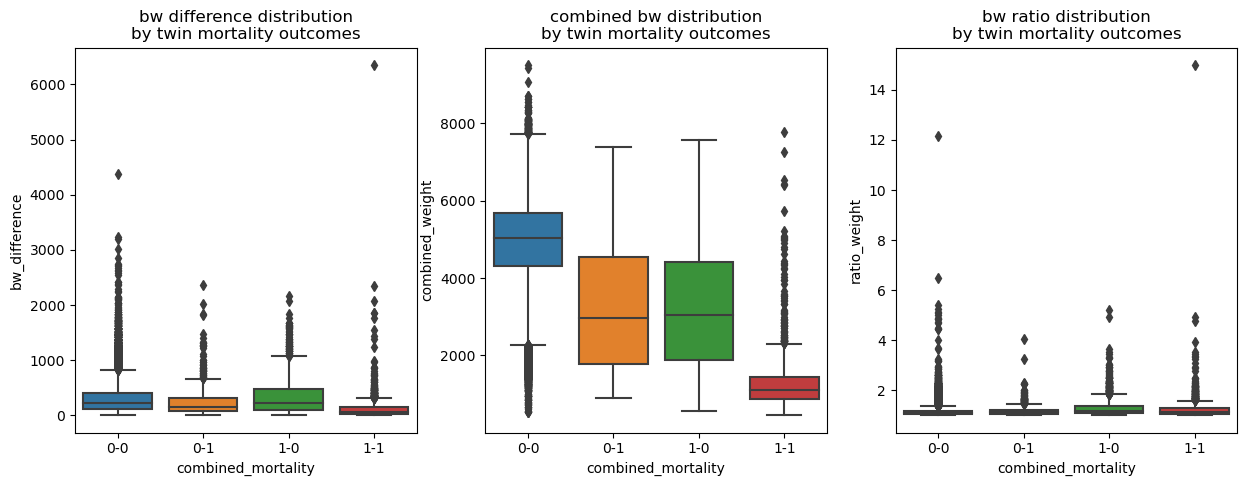

In [61]:
# 3 different ways of combining birthweight
# let's visualize them all in a grid grouped by mortality outcome

plt.subplots(1,3,figsize = (15,5))

plt.subplot(1,3,1)
sns.boxplot(x = 'combined_mortality',y = 'bw_difference',data = df)
plt.title("bw difference distribution\nby twin mortality outcomes")

plt.subplot(1,3,2)
sns.boxplot(x = 'combined_mortality',y = 'combined_weight',data = df)
plt.title("combined bw distribution\nby twin mortality outcomes")

plt.subplot(1,3,3)
sns.boxplot(x = 'combined_mortality',y = 'ratio_weight',data = df)
plt.title("bw ratio distribution\nby twin mortality outcomes")


plt.show()

In [62]:
result = smf.ols(formula='health_outcome_combined ~ combined_weight',data=df[['health_outcome_combined','combined_weight']]).fit()
result.params

Intercept          1.328176
combined_weight    0.000125
dtype: float64

In [63]:
result.summary().tables[0]

Dep. Variable:,health_outcome_combined,R-squared:,0.226
Model:,OLS,Adj. R-squared:,0.226
Method:,Least Squares,F-statistic:,2.079e+04
Date:,"Fri, 28 Jun 2024",Prob (F-statistic):,0.00
Time:,10:31:43,Log-Likelihood:,-13262.
No. Observations:,71345,AIC:,2.653e+04
Df Residuals:,71343,BIC:,2.655e+04
Df Model:,1,,
Covariance Type:,nonrobust,,


In [64]:
# R - squared - .226

# what values can R-squared take? 0-1 (usually)
# do we want R-squared to be big or small? big
# what does an R-squared of zero mean? - your model is not any better than y_hat (predicted y) = mean(y)

# .226

# beta for combined weight 0.000125

# "for a unit change in x (increase the value of x by 1) we see a beta change in y (y + beta)"
# "for every additional gram of combined weight we see a .000125 improvement in the health outcome"

# "for every additional 100 grams of combined weight we see .0125 improvement in the health outcome"

df['combined_weight'].describe()

count    71345.000000
mean      4805.813834
std       1260.089280
min        461.000000
25%       4196.000000
50%       4989.000000
75%       5642.000000
max       9498.000000
Name: combined_weight, dtype: float64

In [65]:
# predicted health outcome = intercept + beta*combined_weight = 1.328176 + 0.000125*combined_weight

def combined_weight_regression(combined_weight):

    predicted_health_outcome = result.params[0] + result.params[1]*combined_weight

    return predicted_health_outcome

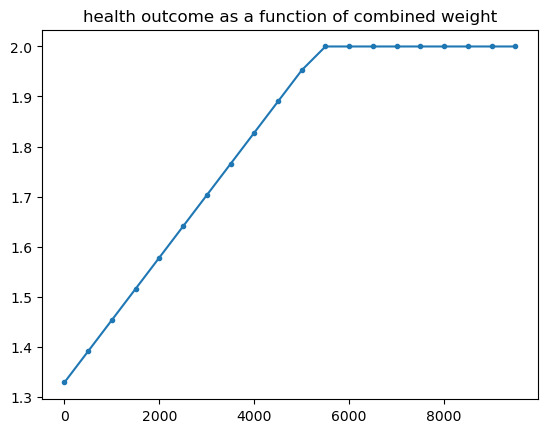

In [66]:
combined_weight_inputs = np.arange(0,10000,500)

predicted_combined_weight = combined_weight_regression(combined_weight_inputs)

predicted_combined_weight = np.where(predicted_combined_weight > 2,2,predicted_combined_weight)

plt.figure()
plt.plot(combined_weight_inputs,predicted_combined_weight,marker = ".")
plt.title("health outcome as a function of combined weight")
plt.show()